### Spoken Language Processing
В этом задании предлагается обучить классификатор класса возраста по голосу (пример с тем, как это можно сделать для пола см. в семинаре)

Подумайте, как лучше предсказывать возраст (может быть разбить на группы?) и какой лосс использовать

P.S. не забудьте, что если то вы работает в Colab, то вы можете поменять среду выполнения на GPU/TPU!

Вопросы по заданию/материалам: @Nestyme

In [1]:
!pip3 install timit-utils==0.9.0
!pip3 install torchaudio
!wget https://ndownloader.figshare.com/files/10256148 
!unzip -q 10256148

In [2]:
import timit_utils as tu
import os
import librosa
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import IPython
from IPython.display import clear_output
_TIMIT_PATH = 'data/lisa/data/timit/raw/TIMIT'

## Задание 1
Загрузите данные для обучения. Для этого:
1. Скачайте датасет TIMIT (см семинар)
2. Соберите пары "голос"  — "класс возраста" также, как на семинаре собирались пары "голос"  — "пол". Аудиодорожки сконвертируйте в мелспектрограммы при помощи `torchaudio либо` `librosa`

P.S. вы можете использовать свою реализацию, а можете предложенную (см следующие ячейки)

In [3]:
import timit_utils as tu
import os
import librosa
import numpy as np
from tqdm import tqdm
import torch as t


class timit_dataloader:
    def __init__(self, data_path=_TIMIT_PATH, train_mode=True, age_mode=True):
        self.doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
        self.corpus = tu.Corpus(data_path)
        with open(self.doc_file_path) as f:
            self.id_age_dict = dict(
                [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
                 for tmp in f.readlines()[39:]])
        if train_mode:
            self.trainset = self.create_dataset('train', age_mode=age_mode)
            self.validset = self.create_dataset('valid', age_mode=age_mode)
        self.testset = self.create_dataset('test', age_mode=age_mode)

    def return_age(self, id):
        return self.id_age_dict[id]

    def return_data(self):
        return self.trainset, self.validset, self.testset

    def return_test(self):
        return self.testset

    def create_dataset(self, mode, age_mode=False):
        global people
        assert mode in ['train', 'valid', 'test']
        if mode == 'train':
            people = [self.corpus.train.person_by_index(i) for i in range(350)]
        if mode == 'valid':
            people = [self.corpus.train.person_by_index(i) for i in range(350, 400)]
        if mode == 'test':
            people = [self.corpus.test.person_by_index(i) for i in range(150)]
        spectrograms_and_targets = []
        for person in tqdm(people):
              try:
                  target = self.return_age(person.name)
                  for i in range(len(person.sentences)):
                      spectrograms_and_targets.append(
                          self.preprocess_sample(person.sentence_by_index(i).raw_audio, target, age_mode=True))
              except:
                  print(person.name, target)

        X, y = map(np.stack, zip(*spectrograms_and_targets))
        X = X.transpose([0, 2, 1])  # to [batch, time, channels]
        return X, y

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    @staticmethod
    def clasterize_by_age(age):
        if age <= 25:
            return 0
        if 25 < age <= 40:
            return 1
        if age > 40:
            return 2

    def preprocess_sample(self, amplitudes, target, age_mode=False, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        target = self.clasterize_by_age(target)
        return self.spec_to_image(np.float32(spectrogram)), target

    def preprocess_sample_inference(self, amplitudes, sr=16000, max_length=150, device='cpu'):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

        return t.tensor(spectrogram, dtype=t.float).to(device, non_blocking=True)


class dataloader:
    def __init__(self, spectrograms, targets):
        self.data = list(zip(spectrograms, targets))

    def next_batch(self, batch_size, device):
        indices = np.random.randint(len(self.data), size=batch_size)

        input = [self.data[i] for i in indices]

        source = [line[0] for line in input]
        target = [line[1] for line in input]

        return self.torch_batch(source, target, device)

    @staticmethod
    def torch_batch(source, target, device):
        return tuple(
            [
                t.tensor(val, dtype=t.float).to(device, non_blocking=True)
                for val in [source, target]
            ]
        )

    @staticmethod
    def padd_sequences(lines, pad_token=0):
        lengths = [len(line) for line in lines]
        max_length = max(lengths)

        return np.array(
            [
                line + [pad_token] * (max_length - lengths[i])
                for i, line in enumerate(lines)
            ]
        )

Простая сверточная сеть, ее можно дотюнить или поменять по желанию

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self, window_sizes=(3, 4, 5)):
        super(Model, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(1, 128, [window_size, 128], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])

        self.fc = nn.Linear(128 * len(window_sizes), 3)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)  # [B, C, T, E] Add a channel dim.
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))  # [B, F, T, 1]
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)  # [B, F, window]

        # FC
        x = x.view(x.size(0), -1)  # [B, F * window]
        logits = self.fc(x)  # [B, class]
        probs = torch.sigmoid(logits) #.view(-1)
        return probs


In [4]:
_timit_dataloader = timit_dataloader()
train, valid, test = _timit_dataloader.return_data()

trainset = dataloader(*train)
validset = dataloader(*valid)
testset = dataloader(*test)

100%|██████████| 150/150 [00:23<00:00,  6.51it/s]


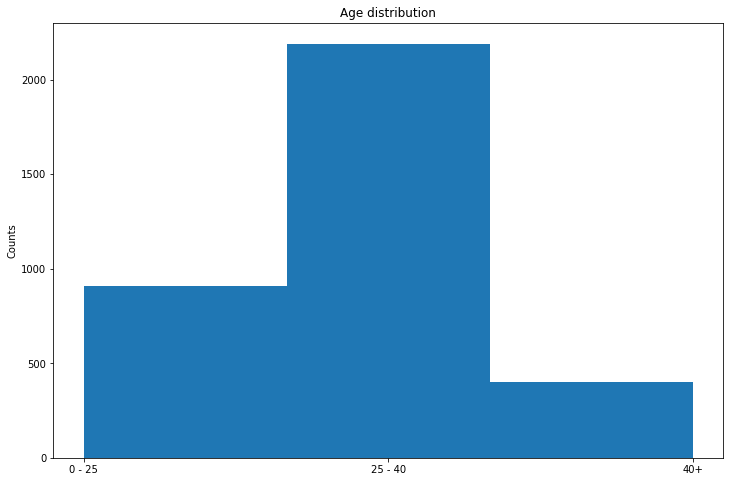

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.ylabel('Counts')
plt.title('Age distribution')
plt.hist(train[1], bins = 3)
plt.xticks(np.arange(3), ['0 - 25', '25 - 40', '40+']) 
plt.show()

In [15]:
unique, counts = np.unique(train[1], return_counts=True)
dict(zip(unique, counts)) 

{0: 910, 1: 2190, 2: 400}

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using {device} mode')
patience = 500
best_loss = 1000
cnt = 0

using cuda mode


In [8]:
!CUDA_LAUNCH_BLOCKING=1 
model = Model()
if device == torch.device('cuda'):
    model.cuda()
else:
    model.cpu()

model.train()

Model(
  (convs): ModuleList(
    (0): Conv2d(1, 128, kernel_size=[3, 128], stride=(1, 1), padding=(2, 0))
    (1): Conv2d(1, 128, kernel_size=[4, 128], stride=(1, 1), padding=(3, 0))
    (2): Conv2d(1, 128, kernel_size=[5, 128], stride=(1, 1), padding=(4, 0))
  )
  (fc): Linear(in_features=384, out_features=3, bias=True)
)

In [6]:
!nvidia-smi

Fri Jun 11 09:13:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
BATCH_SIZE = 64
criterion = nn.CrossEntropyLoss() 
optimizer = Adam([p for p in model.parameters() if p.requires_grad], betas=(0.9, 0.999), eps=1e-5)

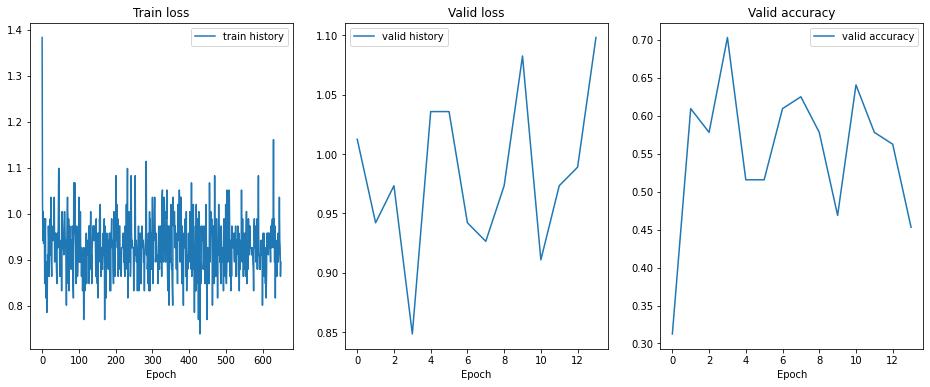

training finished


In [11]:
!CUDA_LAUNCH_BLOCKING=1 
from tqdm import tqdm_notebook
import torch as t
train_history = []
valid_history = []
valid_accuracy = []

for i in tqdm_notebook(range(1000)):

    optimizer.zero_grad()

    input, target = trainset.next_batch(BATCH_SIZE, device=device)
    out = model.forward(input)

    loss = criterion(out, target.long())
    loss.backward()
    optimizer.step()
    
    if i % 50 == 0:
        model.eval()

        with torch.no_grad():

            input, target = validset.next_batch(BATCH_SIZE, device=device)
            out = model(input)
            valid_loss = criterion(out, target.long())
            out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
            out = np.argmax(out, axis=1)
            val_acc = accuracy_score(target, out)
            valid_accuracy.append(val_acc)
            valid_history.append(valid_loss.item())
            print(f'accuracy_score:{accuracy_score(target, out)}')
            print("i {}, valid {}".format(i, valid_loss.item()))
            print("_________")

        model.train()
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
        clear_output(True)
        if train_history is not None:
            ax[0].plot(train_history, label='train history')
            ax[0].set_xlabel('Epoch')
            ax[0].set_title('Train loss')
            ax[0].legend()
        if valid_history is not None:
            ax[1].plot(valid_history, label='valid history')
            ax[1].legend()
            ax[1].set_xlabel('Epoch')
            ax[1].set_title('Valid loss')
        if valid_accuracy is not None:
            ax[2].plot(valid_accuracy, label='valid accuracy')
            ax[2].legend()
            ax[2].set_xlabel('Epoch')
            ax[2].set_title('Valid accuracy')
        plt.legend()
        plt.show()
    train_history.append(loss.item())
    
    if i % 50 == 0 and best_loss > valid_loss.item():
        best_loss = valid_loss.item()
        cnt = 0
    else:
        cnt += 1

    if cnt > patience:
        break
print('training finished')


In [12]:
model.eval()

with torch.no_grad():
            
    input, target = testset.next_batch(BATCH_SIZE, device=device)
    out = model(input)
           
    test_loss = criterion(out, target.long())
    out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
    out = np.argmax(out, axis=1)
    print(f'Test accuracy_score:{accuracy_score(out, target)}')
    print("num_epoch {}, valid {}".format(i, valid_loss.item()))

Test accuracy_score:0.671875
num_epoch 651, valid 1.0983198881149292


#Задание 2
1. Обучите свой классификатор категории возраста
2. Попробуйте улучшить результат. Можно попробовать усложнить сетку, подвигать границы категорий, поискать новые данные, что угодно, кроме учиться на тесте :)
3. Какой подход оказался самым эффективным? Как думаете, почему?
4. Как считаете, где можно было бы применить такой классификатор в качестве вспомогательной задачи?


In [18]:
class MyModel(nn.Module):
    def __init__(self, window_sizes=(3, 4, 5)):
        super(MyModel, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(1, 128, [window_size, 128], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])
        self.bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(p=0.2, inplace=True)
        self.fc = nn.Linear(128 * len(window_sizes), 3)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)  # [B, C, T, E] Add a channel dim.
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))  # [B, F, T, 1]
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)  # [B, F, window]
        x = self.bn(x)
        x =self.dropout(x)

        # FC
        x = x.view(x.size(0), -1)  # [B, F * window]
        logits = self.fc(x)  # [B, class]
        probs = torch.sigmoid(logits) #.view(-1)
        return probs


In [19]:
!CUDA_LAUNCH_BLOCKING=1 
model1 = MyModel()
if device == torch.device('cuda'):
    model1.cuda()
else:
    model1.cpu()

model1.train()

MyModel(
  (convs): ModuleList(
    (0): Conv2d(1, 128, kernel_size=[3, 128], stride=(1, 1), padding=(2, 0))
    (1): Conv2d(1, 128, kernel_size=[4, 128], stride=(1, 1), padding=(3, 0))
    (2): Conv2d(1, 128, kernel_size=[5, 128], stride=(1, 1), padding=(4, 0))
  )
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=True)
  (fc): Linear(in_features=384, out_features=3, bias=True)
)

In [21]:
BATCH_SIZE = 64
criterion = nn.CrossEntropyLoss() 
optimizer = Adam([p for p in model1.parameters() if p.requires_grad], betas=(0.9, 0.999), eps=1e-5)

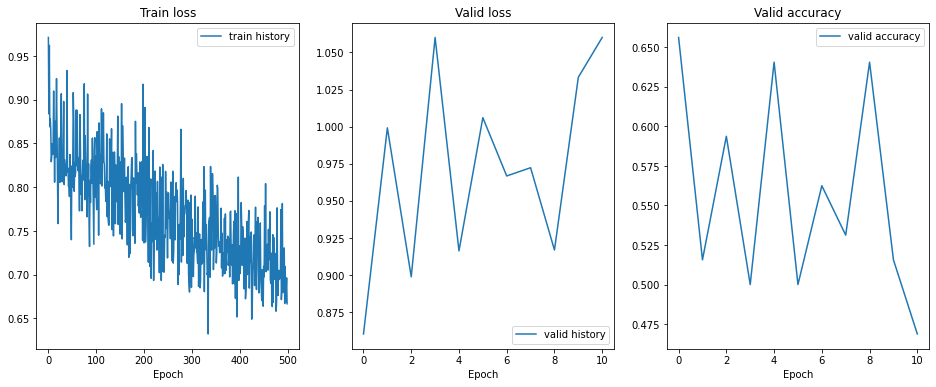

training finished


In [23]:
!CUDA_LAUNCH_BLOCKING=1 
from tqdm import tqdm_notebook
import torch as t
train_history = []
valid_history = []
valid_accuracy = []
for i in tqdm_notebook(range(1000)):

    optimizer.zero_grad()

    input, target = trainset.next_batch(BATCH_SIZE, device=device)
    out = model1.forward(input)

    loss = criterion(out, target.long())
    loss.backward()
    optimizer.step()
    
    if i % 50 == 0:
        model1.eval()

        with torch.no_grad():

            input, target = validset.next_batch(BATCH_SIZE, device=device)
            out = model1(input)
            valid_loss = criterion(out, target.long())
            out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
            out = np.argmax(out, axis=1)
            val_acc = accuracy_score(target, out)
            valid_accuracy.append(val_acc)
            valid_history.append(valid_loss.item())
            print(f'accuracy_score:{val_acc}')
            print("i {}, valid {}".format(i, valid_loss.item()))
            print("_________")

        model1.train()
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
        clear_output(True)
        if train_history is not None:
            ax[0].plot(train_history, label='general train history')
            ax[0].set_xlabel('Epoch')
            ax[0].set_title('Train loss')
            ax[0].legend()
        if valid_history is not None:
            ax[1].plot(valid_history, label='valid history')
            ax[1].legend()
            ax[1].set_xlabel('Epoch')
            ax[1].set_title('Valid loss')
        if valid_accuracy is not None:
            ax[2].plot(valid_accuracy, label='valid accuracy')
            ax[2].legend()
            ax[2].set_xlabel('Epoch')
            ax[2].set_title('Valid accuracy')
        plt.legend()
        plt.show()
    train_history.append(loss.item())

    if i % 50 == 0 and best_loss > valid_loss.item():
        best_loss = valid_loss.item()
        cnt = 0
    else:
        cnt += 1

    if cnt > patience:
        break
print('training finished')


In [24]:
model1.eval()

with torch.no_grad():
            
    input, target = testset.next_batch(BATCH_SIZE, device=device)
    out = model1(input)
           
    test_loss = criterion(out, target.long())
    out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
    out = np.argmax(out, axis=1)
    print(f'Test accuracy_score:{accuracy_score(out, target)}')
    print("Num_epoch {}, valid {}".format(i, valid_loss.item()))

Test accuracy_score:0.640625
Num_epoch 501, valid 1.06012761592865


In [7]:
class MyModel(nn.Module):
    def __init__(self, window_sizes=(3, 4, 5)):
        super(MyModel, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(1, 128, [window_size, 128], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])
        self.bn = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128 * len(window_sizes), 3)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)  # [B, C, T, E] Add a channel dim.
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))  # [B, F, T, 1]
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)  # [B, F, window]
        x = self.bn(x)

        # FC
        x = x.view(x.size(0), -1)  # [B, F * window]
        logits = self.fc(x)  # [B, class]
        probs = torch.sigmoid(logits) #.view(-1)
        return probs


In [8]:
!CUDA_LAUNCH_BLOCKING=1 
model1 = MyModel()
if device == torch.device('cuda'):
    model1.cuda()
else:
    model1.cpu()

model1.train()

MyModel(
  (convs): ModuleList(
    (0): Conv2d(1, 128, kernel_size=[3, 128], stride=(1, 1), padding=(2, 0))
    (1): Conv2d(1, 128, kernel_size=[4, 128], stride=(1, 1), padding=(3, 0))
    (2): Conv2d(1, 128, kernel_size=[5, 128], stride=(1, 1), padding=(4, 0))
  )
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=384, out_features=3, bias=True)
)

In [9]:
BATCH_SIZE = 64
criterion = nn.CrossEntropyLoss() 
optimizer = Adam([p for p in model1.parameters() if p.requires_grad], betas=(0.9, 0.999), eps=1e-5)

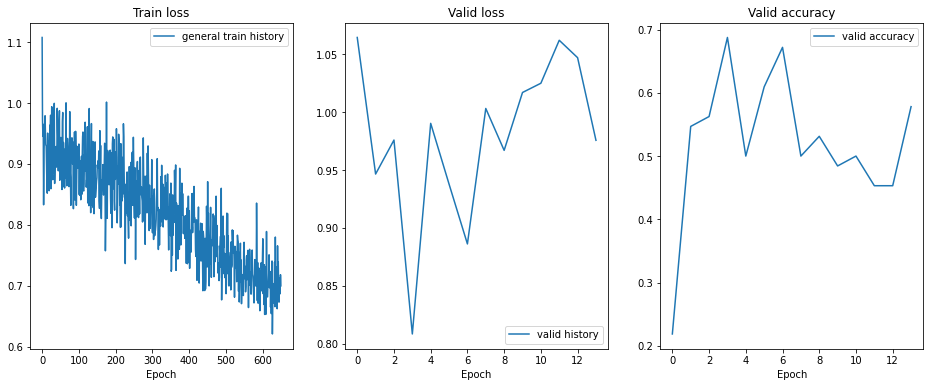

training finished


In [10]:
!CUDA_LAUNCH_BLOCKING=1 
from tqdm import tqdm_notebook
import torch as t
train_history = []
valid_history = []
valid_accuracy = []
for i in tqdm_notebook(range(1000)):

    optimizer.zero_grad()

    input, target = trainset.next_batch(BATCH_SIZE, device=device)
    out = model1.forward(input)

    loss = criterion(out, target.long())
    loss.backward()
    optimizer.step()
    
    if i % 50 == 0:
        model1.eval()

        with torch.no_grad():

            input, target = validset.next_batch(BATCH_SIZE, device=device)
            out = model1(input)
            valid_loss = criterion(out, target.long())
            out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
            out = np.argmax(out, axis=1)
            val_acc = accuracy_score(target, out)
            valid_accuracy.append(val_acc)
            valid_history.append(valid_loss.item())
            print(f'accuracy_score:{val_acc}')
            print("i {}, valid {}".format(i, valid_loss.item()))
            print("_________")

        model1.train()
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
        clear_output(True)
        if train_history is not None:
            ax[0].plot(train_history, label='general train history')
            ax[0].set_xlabel('Epoch')
            ax[0].set_title('Train loss')
            ax[0].legend()
        if valid_history is not None:
            ax[1].plot(valid_history, label='valid history')
            ax[1].legend()
            ax[1].set_xlabel('Epoch')
            ax[1].set_title('Valid loss')
        if valid_accuracy is not None:
            ax[2].plot(valid_accuracy, label='valid accuracy')
            ax[2].legend()
            ax[2].set_xlabel('Epoch')
            ax[2].set_title('Valid accuracy')
        plt.legend()
        plt.show()
    train_history.append(loss.item())

    if i % 50 == 0 and best_loss > valid_loss.item():
        best_loss = valid_loss.item()
        cnt = 0
    else:
        cnt += 1

    if cnt > patience:
        break
print('training finished')

In [11]:
model1.eval()

with torch.no_grad():
            
    input, target = testset.next_batch(BATCH_SIZE, device=device)
    out = model1(input)
           
    test_loss = criterion(out, target.long())
    out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
    out = np.argmax(out, axis=1)
    print(f'Test accuracy_score:{accuracy_score(out, target)}')
    print("Num_epoch {}, valid {}".format(i, valid_loss.item()))

Test accuracy_score:0.53125
Num_epoch 651, valid 0.9756147861480713


# Отчет

Был проведен сравнительный анализ обучения 3 моделей по классификации возраста людей на основе имеющихся записей их голосов.

 В результате наилучшие результаты показала модель с более простой архитектурой: Conv2d c размером  kernel_size = (3, 4, 5) и линейным слоем (384, 3) - accuracy score 0.67 на тестовом датасете. Модель с такой же архитектурой, но с добавлением батч нормализации, ухудшила результат - accuracy score 0.53. 
Модель с такой же архитектурой, но с добавлением батч нормализации и dropout c p = 0.2, показала чуть лучший результат - accuracy score 0.64. 

Все эксперименты проводились с batch_size = 64, количеством эпох 1000 и использованием оптимайзера Adam с learning rate = 1e-5, в качестве loss_function была применена кросс-энтропия.